## TELCO CUSTOMER CHURN PREDICTION ANALYSIS

## BUSINESS UNDERSTANDING 
Every company wants to increase its profits or revenue margin and customer retention is one of the key area industry players focus their resources on. 
For a telecommunication company, they would like to assess whether their customers are churning and at what rate are they quitting using their products. As it is,it is very costly to bring in new customers as costly as retaining customers to continuously use its service and subscriptions. 

#### OBJECTIVES 
1. Build a model to predict whether a customer will churn or not 
2. Key indicators of churn 
3. Retention startegies to implement 

#### HYPOTHESIS 
*NULL HYPOTHESIS* : There is no significant difference in churn rate between the first 36 months and after 36 months

*ALTERNATIVE HYPOTHESIS* : There is a significant difference in churn rate between the first 36 months and after 36 months

#### ANALYTICAL QUESTIONS
1. Which gender is churning at a high rate?
2. Is there a relationship between the monthly charges and the likelyhood to churn?
3. How does the availability of internet services impact churn?
4. Does the presence of a partner impact the churn rate of a customer?
5. What is the lifespan of a customer?
6. Does mode of payment influence the customer to leave?


In [1]:
## IMPORT NECESSARY LIBRARIES 
import pyodbc     
from dotenv import dotenv_values    
import pandas as pd
import numpy as np
import os,pickle

## Import visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## import others
import warnings 

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

#scikit learn import
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn import metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,auc
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold,KFold
 

In [2]:
## Data environment access
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')


# Get the values for the credentials you set in the '.env' 
database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")


connection_string= f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# connect your data using pyodbc
connection=pyodbc.connect(connection_string)

### DATA UNDERSTANDING

TASKS 
1. Load our datasets
2. Check for the quality of the data 
3. Conduct an EDA analysis

##### DATA FEATURES 
| COLUMN | DESCRIPTION|
|:---: | :---         |
|**Gender** | Whether the customer is a male or a female|
|**SeniorCitizen** | Whether a customer is a senior citizen or not|
|**Partner** | Whether the customer has a partner or not (Yes, No)|
|**Dependents** | Whether the customer has dependents or not (Yes, No)|
|**Tenure** | Number of months the customer has stayed with the company|
|**Phone Service** | Whether the customer has a phone service or not (Yes, No)|
|**MultipleLines** | Whether the customer has multiple lines or not|
|**InternetService** | Customer's internet service provider (DSL, Fiber Optic, No)|
|**OnlineSecurity** | Whether the customer has online security or not (Yes, No, No Internet)|
|**OnlineBackup** | Whether the customer has online backup or not (Yes, No, No Internet)|
|**DeviceProtection** | Whether the customer has device protection or not (Yes, No, No internet service)|
|**TechSupport** | Whether the customer has tech support or not (Yes, No, No internet)|
|**StreamingTV** | Whether the customer has streaming TV or not (Yes, No, No internet service)|
|**StreamingMovies** | Whether the customer has streaming movies or not (Yes, No, No Internet service)|
|**Contract** | The contract term of the customer (Month-to-Month, One year, Two year)|
|**PaperlessBilling** | Whether the customer has paperless billing or not (Yes, No)|
|**Payment Method** | The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))|
|**MonthlyCharges** | The amount charged to the customer monthly|
|**TotalCharges** | The total amount charged to the customer|
|**Churn** | Whether the customer churned or not (Yes or No)|


In [4]:
# Now the sql query to get the data is what what you see below.  

query = "SELECT * FROM LP2_Telco_churn_first_3000"

data1 = pd.read_sql(query, connection)
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


### EDA ANALYSIS ON DATA1

In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [6]:
data1.shape

(3000, 21)

In [7]:
data1.duplicated().sum()

0

In [8]:
data1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [9]:
data1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,3000,3000,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3000,2,Male,1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,3000,2,False,2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,3000,2,False,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,3000,2,False,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,3000.0,NaN,NaN,NaN,32.527333,24.637768,0.0,9.0,29.0,56.0,72.0
PhoneService,3000,2,True,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2731,2,False,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,3000,3,Fiber optic,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2349,2,False,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,3000.0,32.527333,24.637768,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,3000.0,65.347400,30.137053,18.400000,35.787499,70.900002,90.262501,118.650002
TotalCharges,2995.0,2301.278315,2274.987884,18.799999,415.250000,1404.650024,3868.725098,8564.750000


#### *Observation* 
--- There are certain columns that have boolean values as their data type.

--- In the customer lifespan which is represented in Tenure column in months has an average of 32 which means that it approximately takes 32 months for a customer to churn. The standard deviation holds at 24 months, median at 29% with the highest churn at 72%. 

--- The monthly charges holds a mean at 65.34 with a standard deviation of 30.13.The median holding at 70%

--- The Total charges holds a mean of 2301.27 and standard deviation of 2274.98. Though the results are inflated a bit and might skew the dataset.

#### *Course of action* 
--- Conversion of the boolean values to interger 

--- Feature scaling on the total charges column.


In [11]:
data1['SeniorCitizen']= data1['SeniorCitizen'].astype(int)

### SECOND DATASET

In [12]:
data2=pd.read_csv("data files\LP2_Telco-churn-second-2000.csv")
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


### EDA ANALYSIS ON DATA2

In [13]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [14]:
data2.shape

(2043, 21)

In [15]:
data2.duplicated().sum()

0

In [16]:
data2.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,2043.0,0.168380,0.374295,0.00,0.000,0.00,0.000,1.00
tenure,2043.0,32.649046,24.376248,0.00,9.000,30.00,55.000,72.00
MonthlyCharges,2043.0,64.712555,29.970010,18.55,35.825,70.25,89.625,118.35


In [18]:
data2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2043,2043,5600-PDUJF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2043,2,Male,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2043.0,NaN,NaN,NaN,0.16838,0.374295,0.0,0.0,0.0,0.0,1.0
Partner,2043,2,No,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2043,2,No,1412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2043.0,NaN,NaN,NaN,32.649046,24.376248,0.0,9.0,30.0,55.0,72.0
PhoneService,2043,2,Yes,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2043,3,No,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2043,3,Fiber optic,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2043,3,No,1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### *Observation* 

--- The total charges are in object data type.

--- The customer lifespan represented in tenure is on average of 32 months with a standard deviation of 24 months and a median of 30%.

--- On monthly charges the average customers range at 64.71 with a standard deviation of 29.97 which is skewed away from the mean. The median is at 70%.

#### *Course of action* 

--- Convert total charges from object to float type.

In [19]:
data2['TotalCharges']= pd.to_numeric(data2['TotalCharges'],errors='coerce')

**CONCAT THE DATASETS**

In [20]:
# concat your dataset 
df= pd.concat([data1,data2], axis=0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [22]:
df.shape

(5043, 21)

In [23]:
df.duplicated().sum()

0

In [24]:
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
TotalCharges,5035.0,2302.062861,2269.483576,18.799999,417.675003,1401.150024,3862.000000,8670.100000


COLUMN CLEANING 

In [26]:
# Create a function to get the columns where False, True, Yes and No are present
def check_column_values(df):
    columns = []
    for column in df.columns:
        unique_values = df[column].astype(str).unique()  # Convert values to strings
        if all(value.lower() in [x.lower() for x in unique_values] for value in ['True', 'False', 'Yes', 'No']):
            columns.append(column)
    return columns
def filtered_target_columns(check_column_values):
    target_columns = check_column_values(df)
    return target_columns
target_columns = filtered_target_columns(check_column_values)
target_columns

['Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'Churn']

In [27]:
# Create a function that maps the column values and replaces True with Yes and False with No
def unify_column_values(df,columns):
    for column in columns:
        df[column]=df[column].replace({True:'Yes',False:'No'})
def unified_columns():
    return target_columns
 
unify_column_values(df,unified_columns())

# Create a function to print the unified columns and the number of values for each category
def get_clean_target_columns(df, target_columns):
    def clean_target_columns(column):
        return column
    result = {}
    for column in df.columns:
        if column in target_columns:
            column_values = df[column].value_counts()
            column_values.columns = [column, 'count']
            result[clean_target_columns(column)] = column_values
    for column, column_df in result.items():
        print(f"\nColumn: {column}")
        print(column_df)
get_clean_target_columns(df, target_columns)


Column: Partner
Partner
No     2585
Yes    2458
Name: count, dtype: int64

Column: Dependents
Dependents
No     3482
Yes    1561
Name: count, dtype: int64

Column: PhoneService
PhoneService
Yes    4554
No      489
Name: count, dtype: int64

Column: MultipleLines
MultipleLines
No                  2424
Yes                 2130
No phone service     220
Name: count, dtype: int64

Column: OnlineSecurity
OnlineSecurity
No                     2507
Yes                    1456
No internet service     429
Name: count, dtype: int64

Column: OnlineBackup
OnlineBackup
No                     2231
Yes                    1732
No internet service     429
Name: count, dtype: int64

Column: DeviceProtection
DeviceProtection
No                     2219
Yes                    1744
No internet service     429
Name: count, dtype: int64

Column: TechSupport
TechSupport
No                     2472
Yes                    1491
No internet service     429
Name: count, dtype: int64

Column: StreamingTV
StreamingT

In [28]:
#reset index
df= df.reset_index(drop=True)

## Data Visualization

### **Univariate analysis**

Skewed:
SeniorCitizen     1.83
tenure            0.23
MonthlyCharges   -0.24
TotalCharges      0.94
dtype: float64
The skewness of numerical features in the dataset is 2.76


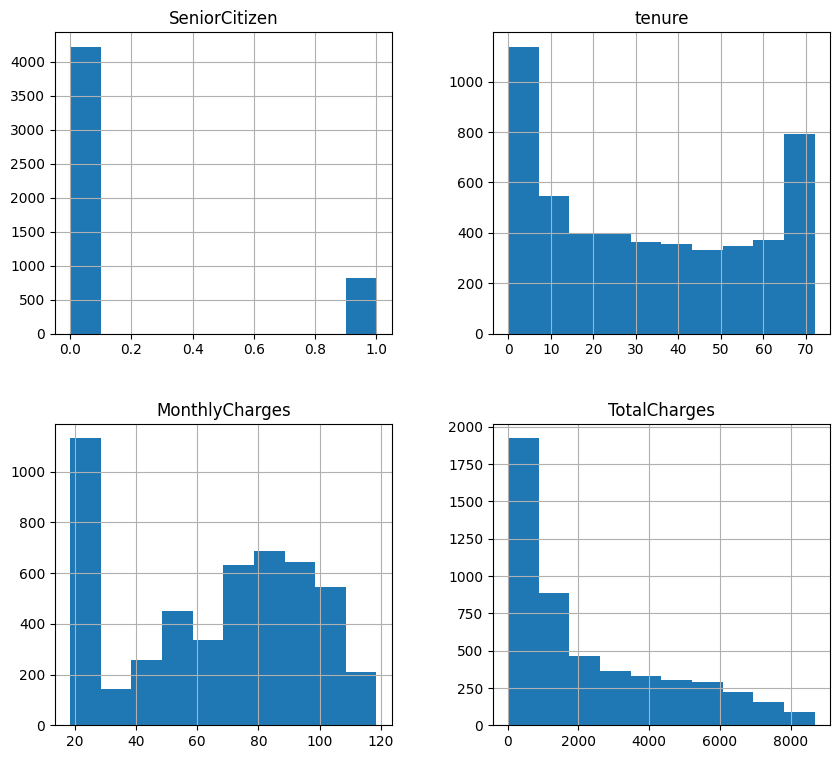

In [29]:
# Check for the skewness and visualize
categoricals = [column for column in df.columns if (df[column].dtype == "O")]
print('Skewed:')
print(round(df.drop(categoricals,axis=1).skew(), 2))


# Total skewness in categorical columns
skew = df.drop(categoricals,axis=1).skew().sum()
print (f'The skewness of numerical features in the dataset is {round(skew,2)}')

# Visualize using histogram
df.hist(figsize=(10,9))
plt.show()

In [30]:
numerics= df.select_dtypes(include=['number']).columns
numerics


for column in df[numerics].columns:
    fig = px.box(df[numerics], y = column,
                 color=df["Churn"], 
                 labels={"color": "Churn"},
                 title = f"Boxplot of the {column} column")
    
    fig.show()

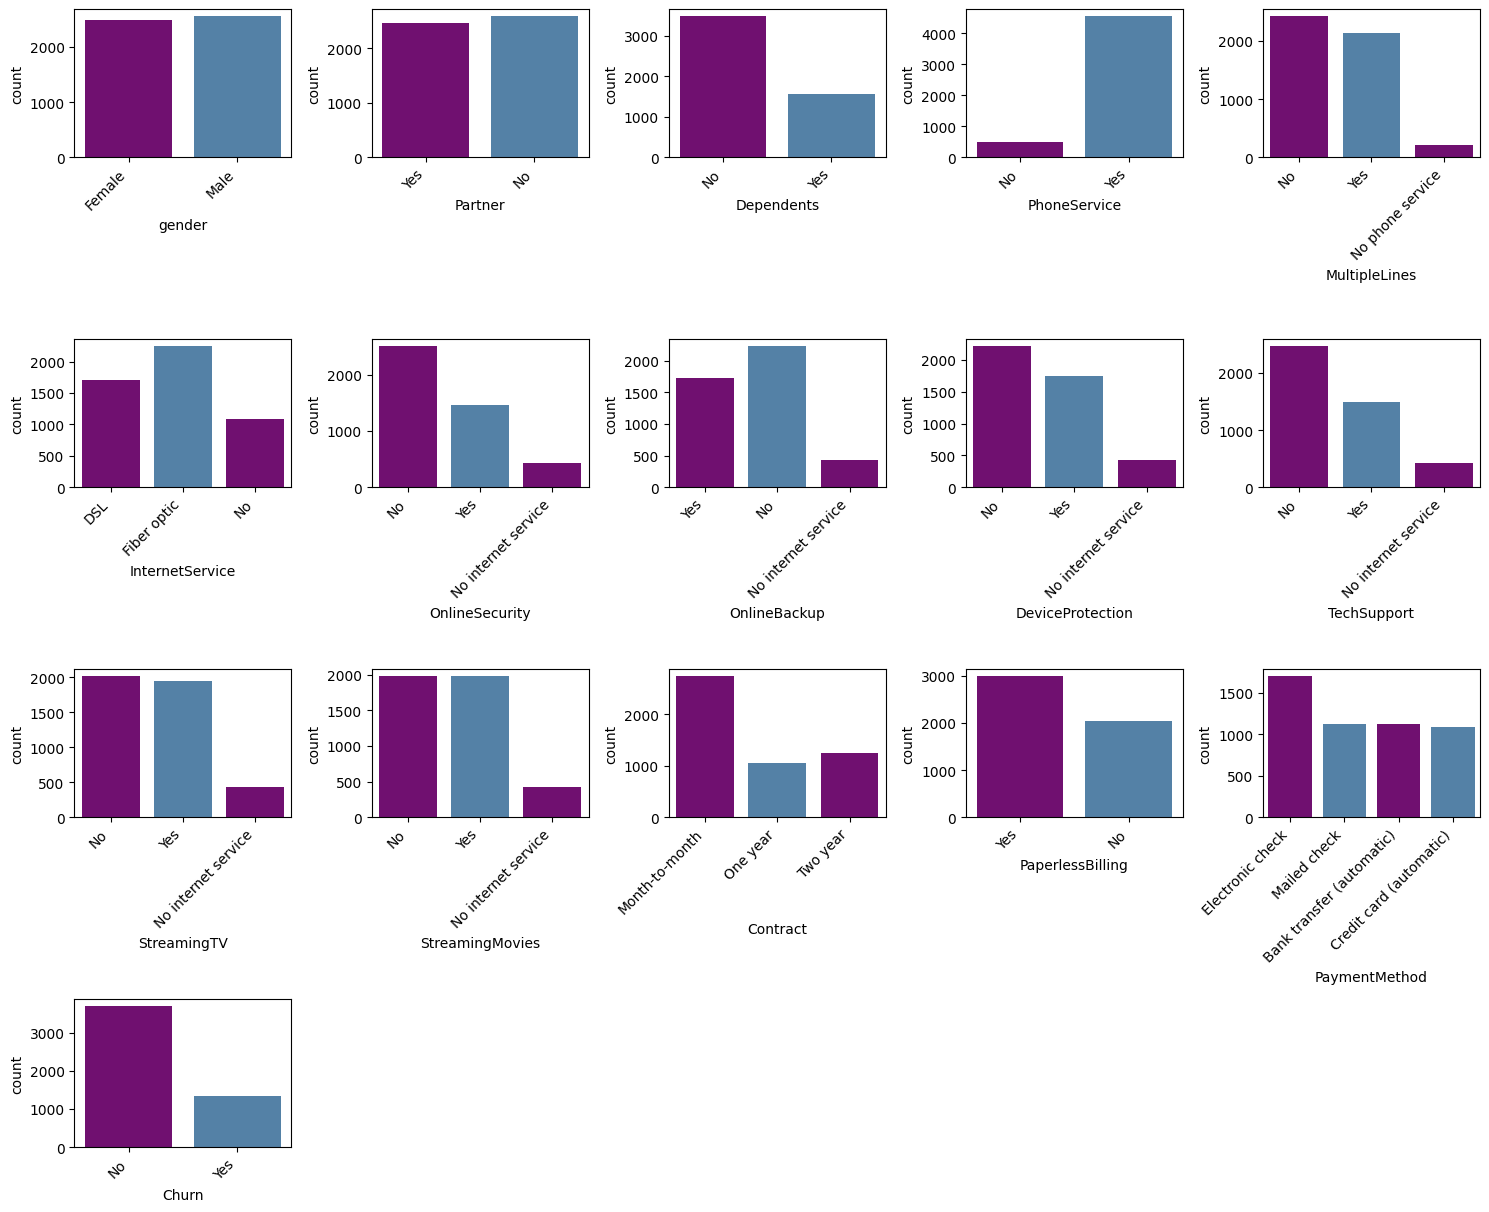

In [31]:
# Setup figure
cols = 5
rows = 5
fig = plt.figure(figsize= (15,15))

# Plotting
all_categorics = df.select_dtypes(include=['object'])
categoric_columns = all_categorics.columns[all_categorics.nunique()<7]
for i, col in enumerate(categoric_columns):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=df[col], data=df, ax=ax, palette=["purple", "steelblue"])    
    plt.xticks(rotation=45, ha='right')
fig.tight_layout()  
plt.show()
     

**OBSERVATIONS**

--- The distribution of the data is skewed. *Total charges* is positively skewed. *Monthly charges* is negatively skewed. *Tenure* is normally distributed.

--- There are outliers in Total charges 

--- There is an even distribution on our categorical columns 

### **BIVARIATE ANALYSIS**

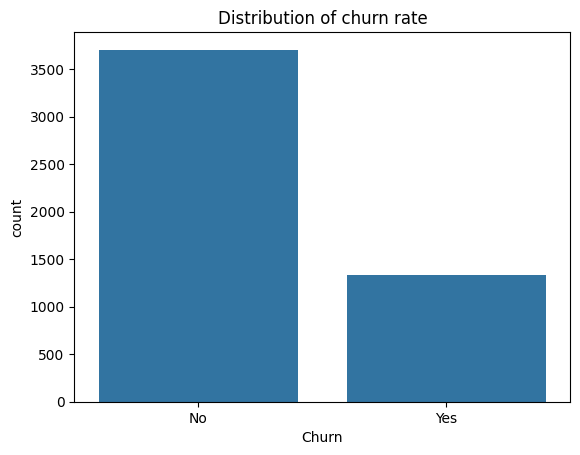

In [32]:
sns.countplot(df, x='Churn')
plt.title('Distribution of churn rate')
plt.show()

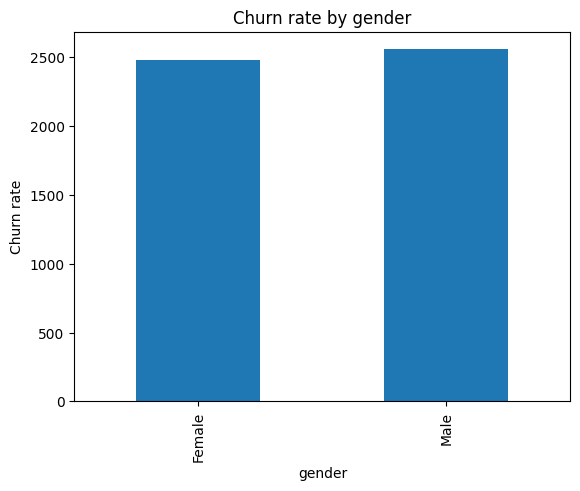

In [33]:
# Calculate the churn rate by gender
churn_rate_by_gender = df.groupby('gender')['Churn'].count()

# Plot the churn rate by gender
churn_rate_by_gender.plot(kind='bar')
plt.ylabel('Churn rate')
plt.title('Churn rate by gender')
plt.show()


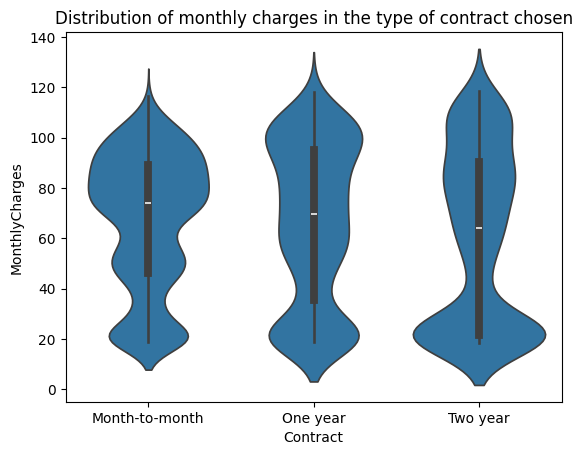

In [34]:
# Check for the relationship of contract type and payments made on a monthly basis
sns.violinplot(data=df, x='Contract', y='MonthlyCharges')
plt.title('Distribution of monthly charges in the type of contract chosen')
plt.show()

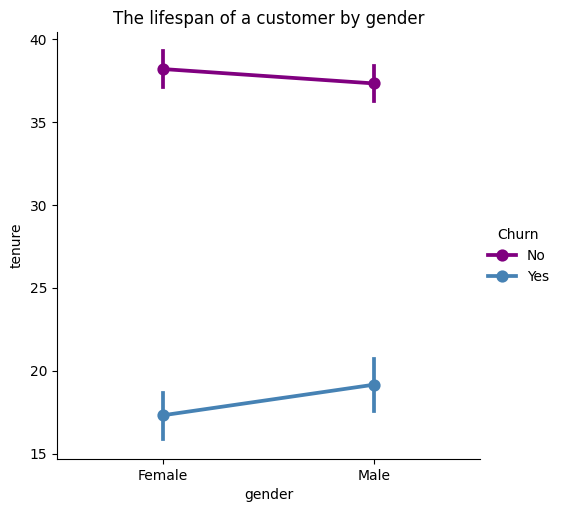

In [35]:
# Check which gender has a minimal lifespan
ax= sns.catplot(data=df, x='gender', y='tenure', hue='Churn', kind='point', palette=['purple', 'steelblue'])
plt.title("The lifespan of a customer by gender")
plt.show()

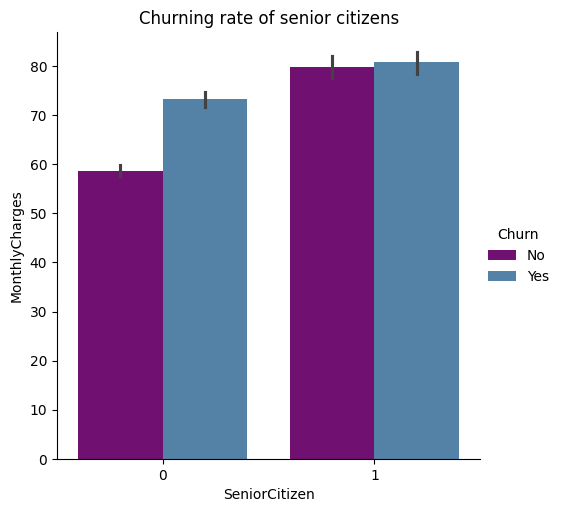

In [36]:
# check whether those who are senior citizens churn more than those who are not
sns.catplot(df, x="SeniorCitizen", y="MonthlyCharges", hue="Churn" , kind="bar",
            palette=["purple", "steelblue"])
plt.title("Churning rate of senior citizens")

plt.show()


**OBSERVATIONS**

--- There is uneven distribution of the churn column with the no being higher.

--- There is an even distribution of the gender column with males being higher than females.

--- For the type of contract chosen, the 2yr type contract has low rate monthly charges whereas for higher monthly charges customers are chosing month to month based contract. Whereas, the one year type contract is evenly distributed with median at the center.

--- The lifespan of a customer based on gender, the males significantly churn at the average lifespan of a customer at 32 months which is quite alarming. Past 32 months the females are not churning as compared to the males, thus to say that males have a low lifespan.

--- Customers who are senior citizens churn higher than those who are not senior citizen in the country. However those that do not churn and are senior citizens are higher than those who churn.

### **MULTIVARIATE ANALYSIS**

In [37]:
# Check for the impact of subscription services 
subscription_services =["StreamingTV", "StreamingMovies"]

subscription_rate= df.groupby("Churn")[subscription_services].count()
subscription_rate

,StreamingTV,StreamingMovies
Churn,,
No,3094,3094
Yes,1297,1297


In [38]:
for column in subscription_rate:
    fig=px.histogram(df, x=df[column], y= "MonthlyCharges", text_auto=True,
                    color_discrete_sequence=["purple","steelblue"],marginal="box",
                     color="Churn")
    
    fig.show()

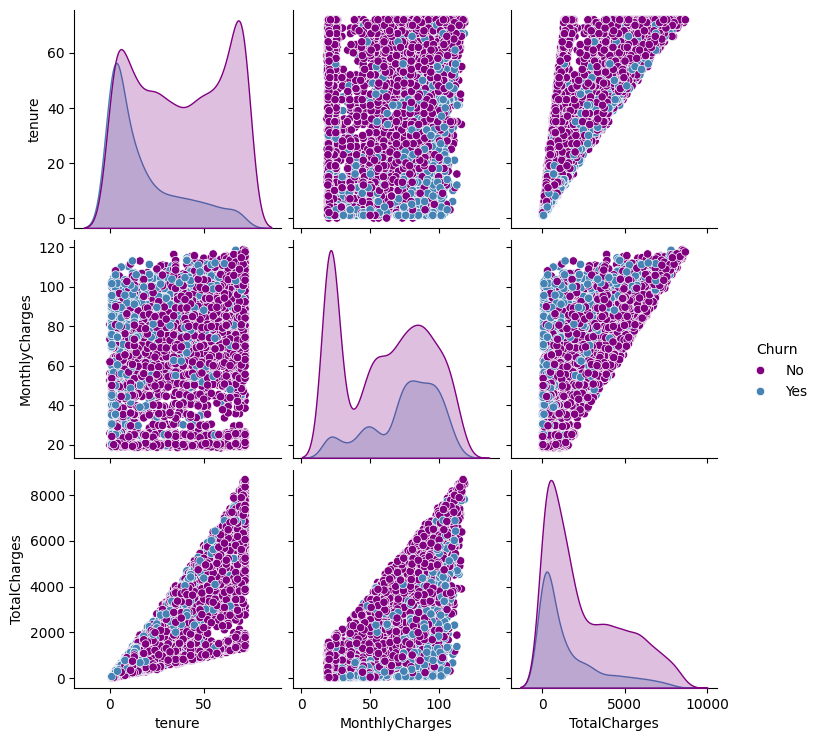

In [39]:
sns.pairplot(df,vars = ['tenure','MonthlyCharges','TotalCharges'], hue="Churn", palette=["purple", "steelblue"])
plt.show()

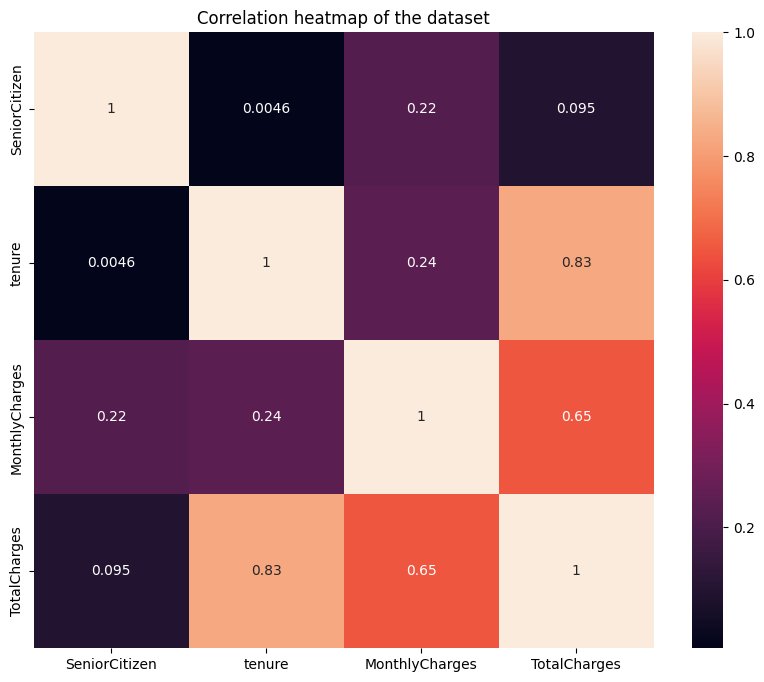

In [40]:
# The correlation of numeric values 
correlation_matrix = df.corr(numeric_only= True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation heatmap of the dataset")
plt.show()

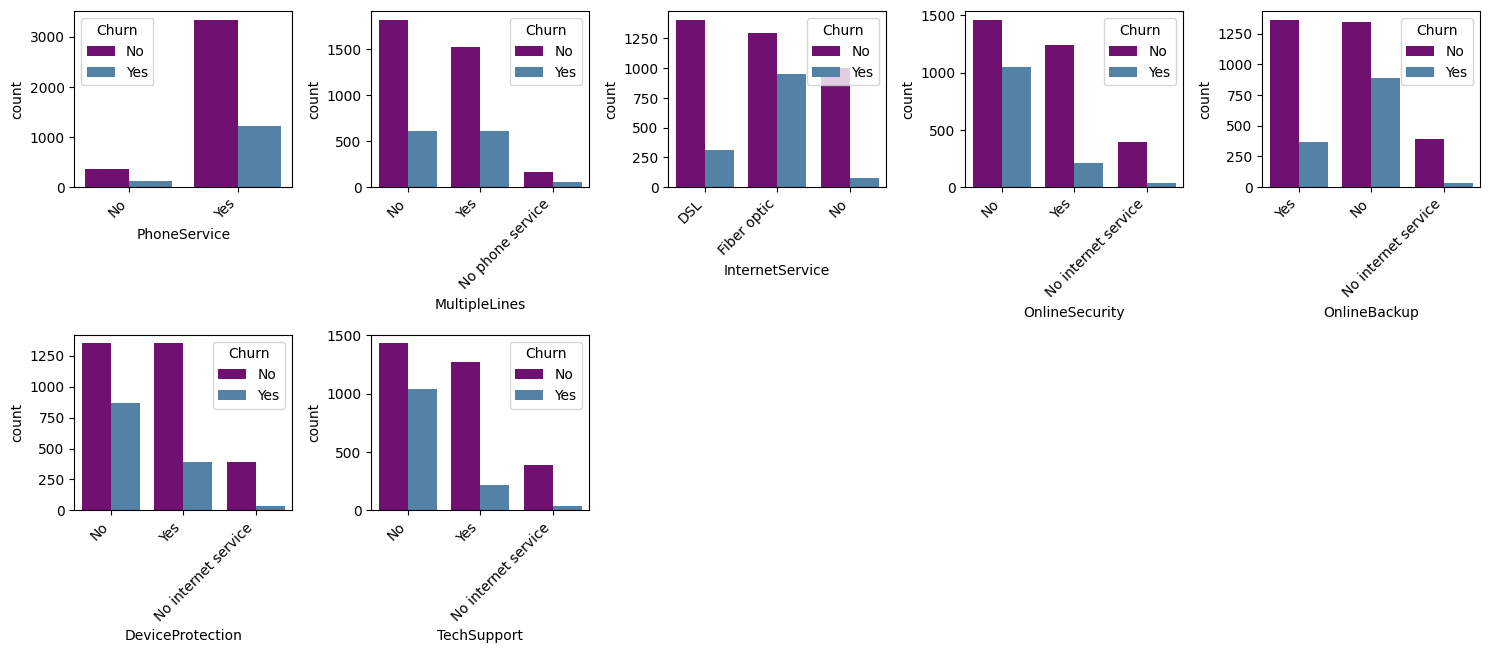

In [41]:
# Setup figure
cols = 5
rows = 5
fig = plt.figure(figsize= (15,15))

# Variation of service attributes offered by the telecommunication company
service_attributes=df[['PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection','TechSupport'
                    ]]
service_attributes

for i, col in enumerate(service_attributes):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=df[col], data=df, ax=ax, palette=["purple", "steelblue"], hue="Churn")    
    plt.xticks(rotation=45, ha='right')
fig.tight_layout()  
plt.show()

**OBSERVATIONS**

--- Customers subscription services have no impact in the churn rate and most customers have a high preference for usage of subscription services

--- There is a significant correlation between tenure and total charges with a rate of 0.83.

--- There is no impact in churn rate distribution between monthly charges, total charges and tenure. With no churn distributed highly across the pair plot against the columns.

--- There is no effect of churn and the service attributes being offered by the telecommunication company. However, because of the distribution of the variables may mislead the analysis thus a deeper dive is required.

### **ANALYTICAL QUESTIONS**

Q1. Which gender is churning at a high rate?

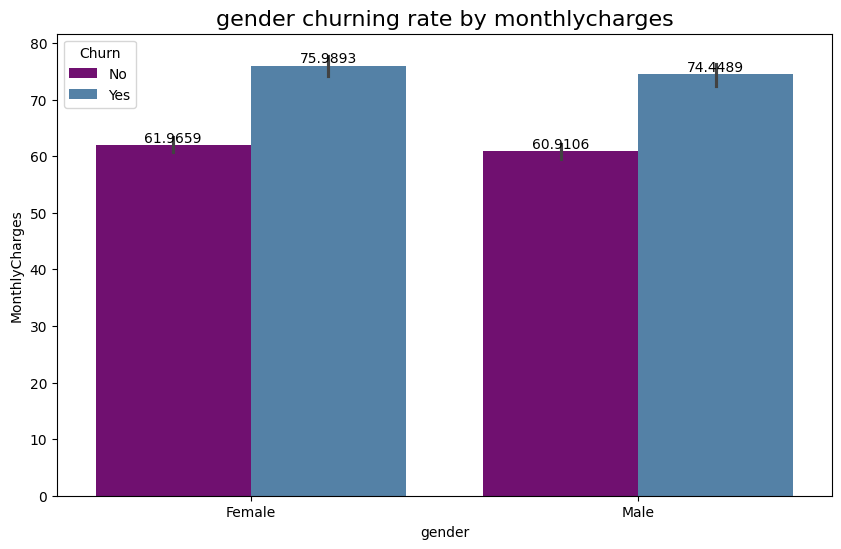

In [42]:
plt.figure(figsize=(10,6))
ax= sns.barplot(data=df, x='gender', y='MonthlyCharges', hue='Churn', legend=True, palette=['purple', 'steelblue'])
plt.title('gender churning rate by monthlycharges', fontsize= 16)
for i in ax.containers:
    ax.bar_label(i,)

#### *REVIEW*

*Both genders seem to be impacted and are churning at a high rate but females are leading with 3% larger than the males however, they still remain to be the highest gender that is not churning.*

Q2. Is there a relationship between the monthly charges and the likelyhood to churn?

In [43]:
monthlycharge_churn= df.groupby('Churn')['MonthlyCharges'].agg(['sum'])
monthlycharge_churn

,sum
Churn,
No,227658.400004
Yes,100481.900005


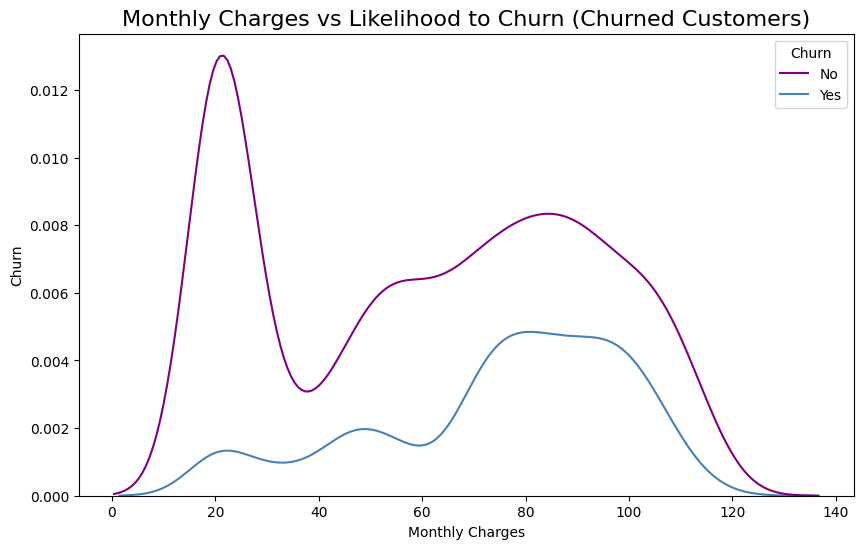

In [44]:
# Create a plot with seaborn
plt.figure(figsize=(10,6))
sns.kdeplot(x='MonthlyCharges', data=df, hue='Churn', legend=True, palette=['purple', 'steelblue'])

# Set the title and labels
plt.title("Monthly Charges vs Likelihood to Churn (Churned Customers)", fontsize=16)
plt.xlabel('Monthly Charges')
plt.ylabel('Churn')

# Show the plot
plt.show()

#### *REVIEW*

*The amount which a customer pays is influencing the churn rate. From the graph, the more monthly charges a customer incurs the more likely he or she is going to leave the company especially where charges are ranging from 80 to 100*. 
Nevertheless, the impact of monthly charges affecting churn is low.

Q3. How does availability of internet services impact churn?

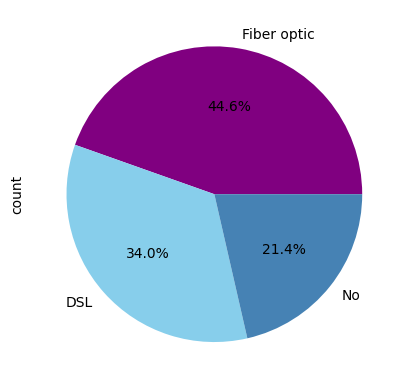

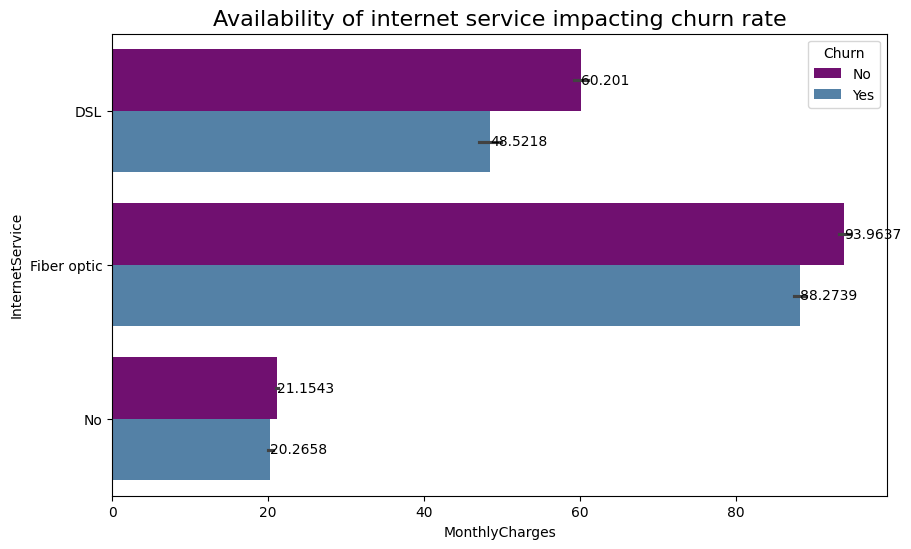

In [45]:
# Check for the counts of internet service
df['InternetService'].value_counts().plot.pie( 
                                              colors=["purple","skyblue","steelblue"],
                                              autopct="%1.1f%%")
plt.show()

# Plot intenet service against churn
plt.figure(figsize=(10,6))
ax= sns.barplot(data=df, y='InternetService', x='MonthlyCharges',
                hue='Churn', orient='h', palette=["purple","steelblue"])
plt.title("Availability of internet service impacting churn rate", fontsize=16)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

#### *REVIEW* 

*The Internet service of choice for most customers is fiber optic leading at 44.6% followed by DSL at 34%. Nevertheless, the most preferred internet service is also the most churned among the three services at 88% but in regards internet services does not impact the rate at which customers are leaving as the No is higher than the yes for all the internet services*

Q4. DOES THE PRESENCE OF A PARTNER AFFECT THE LIKELY HOOD OF CUSTOMER CHURN

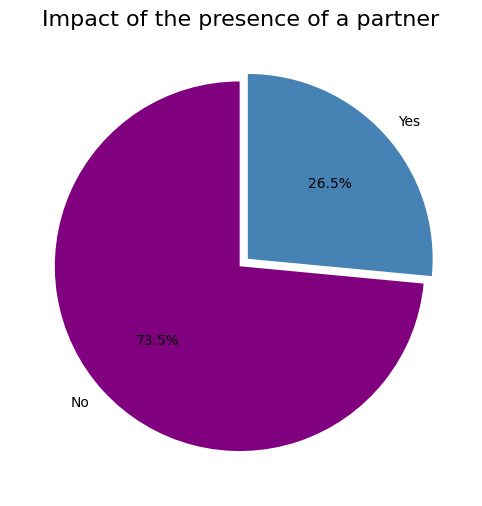

In [46]:
Partner= df.groupby('Churn')['Partner'].count().rename('Totalcount').reset_index()
Partner
plt.figure(figsize=(10,6))
plt.pie(data=Partner, labels='Churn', x='Totalcount',startangle=90, 
        autopct="%1.1f%%",
        explode=(0.01,0.05),
        colors=["purple", "steelblue"])
plt.title("Impact of the presence of a partner", fontsize=16)
plt.show()

#### *REVIEW* 

*While there are those who are impacted by the presence of a partner, 73.5% of customers leaving have not been influenced by their partners*

Q5. What is the lifespan of customers?

Average lifespan of a customer:  32.5766408883601


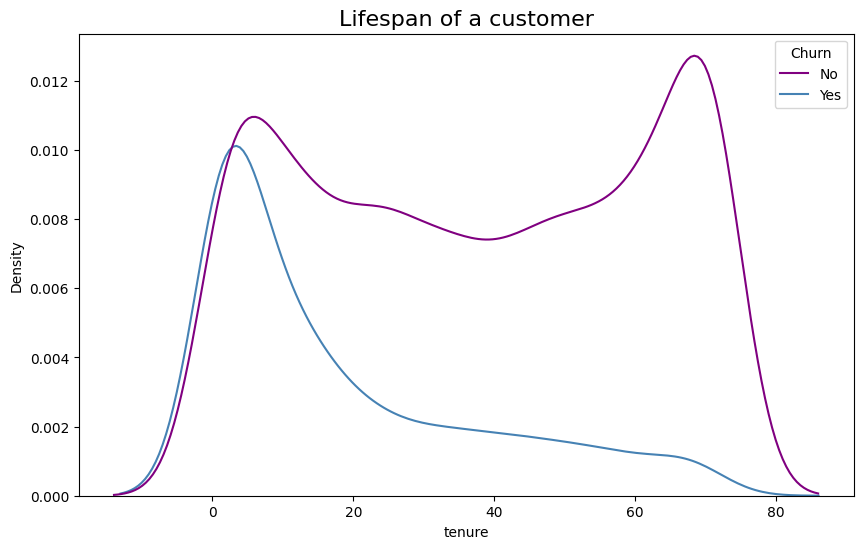

In [47]:
# Calculate the average lifespan of a customer
avg_lifespan = df["tenure"].mean()
print("Average lifespan of a customer: ", avg_lifespan)

# Visualize the lifespan overtime 
plt.figure(figsize=(10,6))
ax= sns.kdeplot(data=df, x='tenure', hue='Churn', 
                legend=True, palette=['purple','steelblue'])
plt.title("Lifespan of a customer", fontsize=16)
plt.show()

#### Review

*The average customer churns at 32 months which is close to 2 to 3 years.However, the majority of customers leaving at a high rate between entry point of experiencing the service and 20 months.*
Needless to say that customers still maintain using their services more than leaving hence increasing their stay period.

Q6. DOES MODE OF PAYMENT INFLUENCE THE CUSTOMER TO LEAVE?

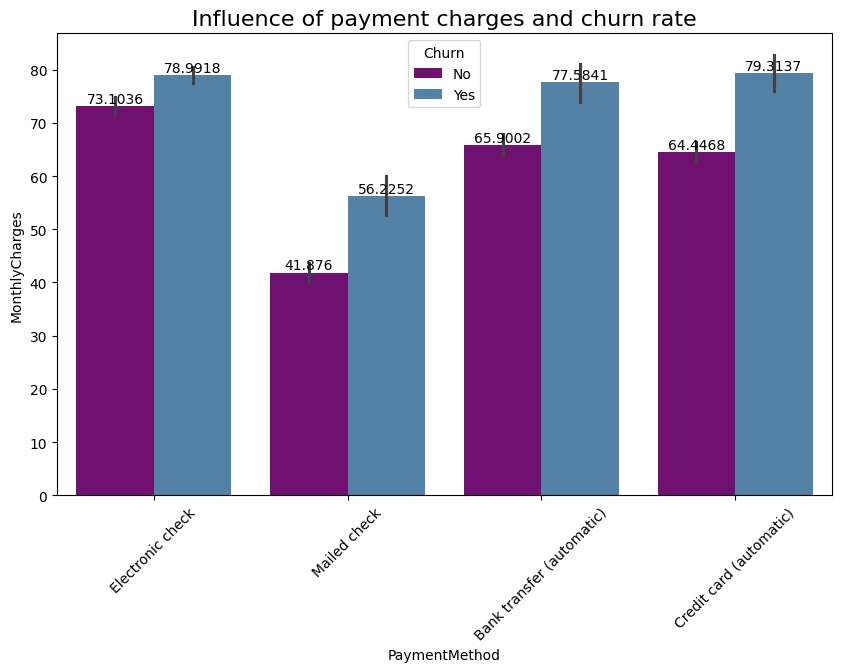

In [48]:
plt.figure(figsize=(10,6))
ax= sns.barplot(data=df, x='PaymentMethod', y='MonthlyCharges', hue='Churn', palette=['purple', 'steelblue'])
plt.title('Influence of payment charges and churn rate', fontsize=16)
plt.xticks(rotation=45)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

#### Review

*Credit card automatic had a major influence in the level of customer churn with a rate of 79% followed with Electronic check at 78%. This means that the mode of payment is affecting the rate at which customers are interacting with the payment services being offered by the company.*

### HYPOTHESIS 

*NULL HYPOTHESIS* : There is no significant difference in churn rate between the first 36 months and after 36 months 

*ALTERNATIVE HYPOTHESIS* : There is a significant difference in churn rate between the first 36 months and after 36 months

In [49]:
import scipy.stats as stats
from scipy.stats import chi2_contingency
# Create a subset of the DataFrame with 'churn' and 'tenure' columns
churn_tenure = df[['Churn', 'tenure']]

# Create a new column to categorize the tenure period
churn_tenure['tenure_period'] = pd.cut(churn_tenure['tenure'], bins=[-1, 36, float('inf')], labels=['0-36 months', 'After 36 months'])

# Create a contingency table
contingency_table = pd.crosstab(churn_tenure['Churn'], churn_tenure['tenure_period'])

# Perform chi-square test for independence
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Define the significance level (alpha)
alpha = 0.05

# Interpret the results of the chi-square test
if p_value < alpha:
    print("Reject the null hypothesis. The churn rate is significantly different between the first 36 months and after 36 months of tenure.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in churn rate between the first 36 months and after 36 months of tenure.")
print(f'The p-value is {p_value}')
print(f'The chi-square statistic is {chi2}')

Reject the null hypothesis. The churn rate is significantly different between the first 36 months and after 36 months of tenure.
The p-value is 2.158392981972549e-88
The chi-square statistic is 397.27503392819733


**Check for churn rates**

In [50]:
# Create a subset of the DataFrame with 'churn' and 'tenure' columns
churn_tenure = df[['Churn', 'tenure']]

# Create a new column to categorize the tenure period
churn_tenure['tenure_period'] = pd.cut(churn_tenure['tenure'], bins=[-1, 36, float('inf')], labels=['0-36 months', 'After 36 months'])

# Calculate churn rates for each tenure period
churn_rates = churn_tenure.groupby('tenure_period')['Churn'].value_counts(normalize=True).mul(100).rename('Churn Rate').reset_index()

# Print the churn rates
print(churn_rates)

     tenure_period Churn  Churn Rate
0      0-36 months    No   62.738964
1      0-36 months   Yes   37.261036
2  After 36 months    No   87.806005
3  After 36 months   Yes   12.193995


**FINDINGS**

--- Indeed the lifespan of a customer is ranged in the first 36 months with a churn rate of 37% higher than the rate at which customers churn after 36 months with a difference of 25%. Thus, we rejected the null hypothesis and seek to find further how best we can improve the model.

--- Worth noting that those who do not churn are at 62% at the start of 36 months and increased no churn rate at 87% to say that there is a variable influencing the customers to leave at the early stages.

### **KEY INSIGHTS**

--- The total charges is positive skewed, hence it may inflate our model. Our monthly charges is negatively skewed. Tenure is normally distributed.

--- The churn column is highly imbalanced.

--- There is also a significant difference between the lifespan of a customer and churn rate. More customers are churning at the beginning of using the services.

--- Among the attributes/ services that impact the churning of the customer include: monthly charges, mode of payment, gender and tenure. The company needs to delve down into these key aspects.

--- The lifespan of a customers is also closely correlated with the total charges a customer pays thus this need further assessment. 


### **RECOMMENDATIONS**

There is a need of assessment in terms of how they offer services to its customers and the charges in which a customer incurs while using the service. Some of the  recommendation would be:

--- Offering after sales services in order to gain customer feedback.

--- Restructring of the price offerings that favour the majority.

--- Creating a more seamless and effortless payment mode transactions and offering extension to contracts attracting more customers to sign up for longer contract services.

--- Bringing on board customer partners and offering offers to them and create loyalty coupons for those with partners.


## **DATA PREPARATION AND CLEANING**

*TASKS*

1.  Fill in the missing values 

2.  Feature scaling the numeric columns

3.  Drop useless columns if any 

4.  Clean the categorical columns by creating uniformity of variables 

5.  Feature engineering of the columns through encoding.

In [51]:
# replace and lower column names
df.columns = [col_name.lower() for col_name in df.columns]
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,0,No,No,45,No,None,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


In [52]:
# drop customer ID Column
df.drop('customerid', axis=1, inplace=True )

In [53]:
# Drop rows with null values in the 'churn' column
df.dropna(subset=['churn'], inplace=True)

In [54]:
df['churn'].value_counts().rename("total").reset_index()

,churn,total
0,No,3706
1,Yes,1336


In [55]:
# df.to_csv("new_data.csv")

#### DATASET SPLIT

In [56]:
# lets now split our data to train, evaluate and test the model

#predictor variables
X = df.drop(columns=["churn"], axis=1)
y = df["churn"]

# #split data
X_train, X_eval, y_train, y_eval = train_test_split(X, y, train_size = 0.8, stratify=y, random_state=42)
(X_train.shape, y_train.shape), (X_eval.shape, y_eval.shape)


(((4033, 19), (4033,)), ((1009, 19), (1009,)))

In [57]:
#Get categorical columns
categorical_columns=X.select_dtypes('object').columns

#Get numerical columns
numerical_columns=X.select_dtypes('number').columns

In [58]:
## Encode your target column
targ= LabelEncoder()
y_trained= targ.fit_transform(y_train)
y_evaled = targ.transform(y_eval)

## instantiate your one hot encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore',dtype=np.float64)

## **MODELLING**

In [59]:
# prepare numerical pipeline
numerical_pipeline=Pipeline(steps=[
('numerical_imputer',SimpleImputer(strategy='median')),
('scaler', RobustScaler())
    
])

# prepare categorical pipeline
categorical_pipeline=Pipeline(steps=[
    ('categorical_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())

])

# Column transformer preparation
preprocessor=ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline,numerical_columns),
    ('categorical_pipeline', categorical_pipeline, categorical_columns)
])

In [60]:
# Instantiate models
models = [
    ('XGB', xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8
    )),
    ('Decision_Tree', DecisionTreeClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=7)),
    ('Logistic_Regression', LogisticRegression(random_state=42)),
    ('Random_Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Gradient_Boosting', GradientBoostingClassifier(random_state=42)),
    ("svm" , SVC(kernel="rbf", gamma=0.5, C=1.0))
]

In [61]:
sm = SMOTE(sampling_strategy=0.8, k_neighbors=3,random_state=42)

**IMBALANCED DATASET**

In [62]:
# all pipelines storage dictionary
all_pipelines={}

#creating a metrics dataframe 
metrics_table=pd.DataFrame(columns=['Model_Name','Accuracy','Precision', 'Recall','F1_Score'])
for model, classifier in models:

    # creating final pipeline
    final_pipeline=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    #fit data to final pipeline
    final_pipeline.fit(X_train, y_trained)
    all_pipelines[model]=final_pipeline

    #Predicting
    y_pred=final_pipeline.predict(X_eval)
    metrics=classification_report(y_evaled, y_pred, output_dict=True)

   #Get all the metrics of interest
    Accuracy=metrics['accuracy']
    Precision=metrics['weighted avg']['precision']
    Recall=metrics['weighted avg']['recall']
    F1_Score=metrics['weighted avg']['f1-score']

    metrics_table.loc[len(metrics_table)]=[model, Accuracy, Precision, Recall, F1_Score]

metrics_table.sort_values(by='F1_Score', ascending=False, ignore_index=True)

,Model_Name,Accuracy,Precision,Recall,F1_Score
0,Gradient_Boosting,0.812686,0.805613,0.812686,0.807705
1,XGB,0.800793,0.792688,0.800793,0.795187
2,Logistic_Regression,0.796829,0.791724,0.796829,0.793807
3,KNN,0.787909,0.783168,0.787909,0.785193
4,svm,0.789891,0.777629,0.789891,0.779929
5,Random_Forest,0.784936,0.774389,0.784936,0.777509
6,Decision_Tree,0.718533,0.728233,0.718533,0.722838


**BALANCED DATASET**

In [63]:
# Instantiate the models
## Logistic Regression
log_reg = LogisticRegression(random_state=42)

## Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)

## Random forest classifier
rd_clf = RandomForestClassifier(random_state=42, n_estimators=100)

## XGBoost
xgb_clf = XGBClassifier(random_state=42, n_jobs = -1, verbose = False)

## KNeighbor classifier
Kn_clf= KNeighborsClassifier(n_neighbors=3)

## Support vector machines
svm = SVC(kernel="rbf", gamma=0.5, C=1.0, probability=True)


In [64]:
## logistics regressor
clf = imbpipeline(steps=[("preprocessor", preprocessor),("smote",sm), ("classifier", log_reg)])

In [65]:
## Xgboost classifier
xgb_clf1 = imbpipeline(steps=[("preprocessor", preprocessor),("smote",sm),("classifier", xgb_clf)])

In [66]:
## Decision tree classifer
dt_clf1 = imbpipeline(steps=[("preprocessor", preprocessor),("smote",sm),("classifier", dt_clf)])

In [67]:
# KNeighbors classifier report
clf_1 = imbpipeline(steps=[("preprocessor", preprocessor),("smote",sm),("classifier", Kn_clf)])

In [68]:
## Random forest classifier
rd_clf1 = imbpipeline(steps=[("preprocessor", preprocessor),("smote",sm),("classifier", rd_clf)])

In [69]:
## Support vector machine
svc_clf = imbpipeline(steps=[("preprocessor", preprocessor),("smote",sm),("classifier", svm)])

In [70]:
def model_report(X_eval=X_eval, y_eval=y_eval):
    # Trained model
    trained_models = dict()

    #instantiate your pipeline models
    models = [
        ("Decision_Tree", dt_clf1),
        ("RandomForestClassifer", rd_clf1),
        ("KNeighbors", clf_1),
        ("Logistics_regressor", clf),
        ("Xgboost", xgb_clf1),
        ("Support_vector", svc_clf)
    ]
    
    # list to receive the scores
    evaluation =[]
    for name, model in models:
        model= model.fit(X_train, y_trained)
        y_pred= model.predict(X_eval)
        evaluation.append([name, 
                             accuracy_score(y_evaled, y_pred),  # accuracy
                             precision_score(y_evaled, y_pred, average="weighted"),  # precisions
                             recall_score(y_evaled, y_pred,average="weighted"),  # recall
                             f1_score(y_evaled, y_pred, average="weighted")
                             ])
 
        # Print classification report
        model_report = classification_report(y_evaled, y_pred)
        print("This is the classification report of the", name, "model", "\n", model_report, "\n")

        # visualize using confusion matrix 
        # Defining the Confusion Matrix
        model_conf_mat = confusion_matrix(y_evaled, y_pred)
        model_conf_mat = pd.DataFrame(model_conf_mat).reset_index(drop=True)
        print(f"Below is the confusion matrix for the {name} model")

        # Visualizing the Confusion Matrix
        fig, ax = plt.subplots()
        sns.heatmap(model_conf_mat, annot=True, linewidth=1.0,fmt=".0f", cmap="RdPu", ax=ax)
        plt.xlabel = ("Prediction")
        plt.ylabel = ("Actual")
        plt.show()

        # Store trained model
        trainedmodelname = "trained_" + str(name).lower()
        trained_models[trainedmodelname] = model
        
        print("\n", "-----   -----"*6, "\n",  "-----   -----"*6, "\n")
        
        # Compile accuracy
    df_compare = (pd.DataFrame(evaluation, columns=["model", "accuracy", "precision", "recall", "f1_score"]).set_index("model"))
    df_compare.sort_values(by=["accuracy", "precision", "recall", "f1_score"], ascending=False, inplace=True)
    return df_compare, trained_models
     

This is the classification report of the Decision_Tree model 
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       742
           1       0.47      0.55      0.51       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.65      1009
weighted avg       0.73      0.72      0.72      1009
 

Below is the confusion matrix for the Decision_Tree model


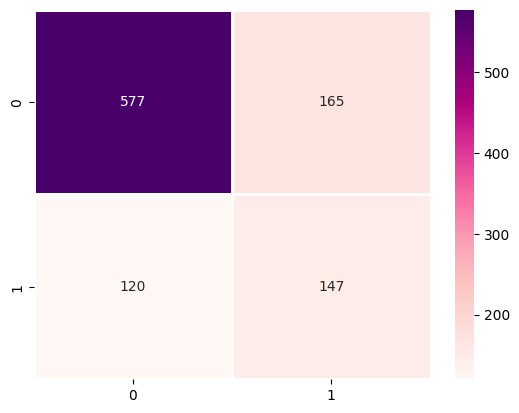


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the RandomForestClassifer model 
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       742
           1       0.58      0.54      0.56       267

    accuracy                           0.78      1009
   macro avg       0.71      0.70      0.71      1009
weighted avg       0.77      0.78      0.77      1009
 

Below is the confusion matrix for the RandomForestClassifer model


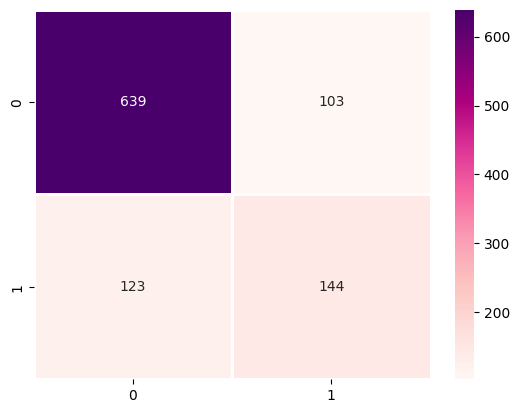


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the KNeighbors model 
               precision    recall  f1-score   support

           0       0.85      0.71      0.78       742
           1       0.45      0.66      0.54       267

    accuracy                           0.70      1009
   macro avg       0.65      0.69      0.66      1009
weighted avg       0.75      0.70      0.71      1009
 

Below is the confusion matrix for the KNeighbors model


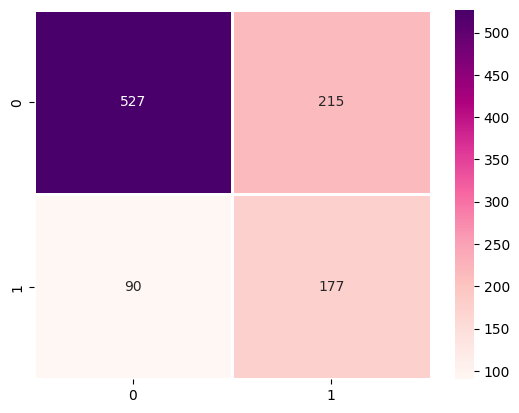


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the Logistics_regressor model 
               precision    recall  f1-score   support

           0       0.90      0.77      0.83       742
           1       0.54      0.77      0.64       267

    accuracy                           0.77      1009
   macro avg       0.72      0.77      0.73      1009
weighted avg       0.81      0.77      0.78      1009
 

Below is the confusion matrix for the Logistics_regressor model


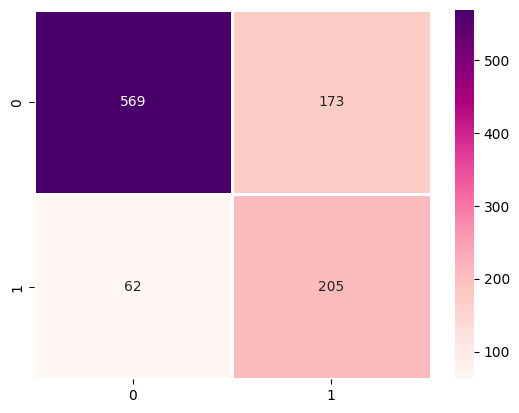


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the Xgboost model 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       742
           1       0.58      0.58      0.58       267

    accuracy                           0.78      1009
   macro avg       0.71      0.72      0.72      1009
weighted avg       0.78      0.78      0.78      1009
 

Below is the confusion matrix for the Xgboost model


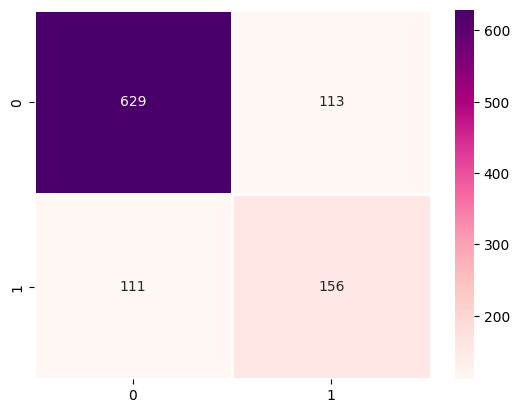


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 

This is the classification report of the Support_vector model 
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       742
           1       0.57      0.55      0.56       267

    accuracy                           0.77      1009
   macro avg       0.70      0.70      0.70      1009
weighted avg       0.77      0.77      0.77      1009
 

Below is the confusion matrix for the Support_vector model


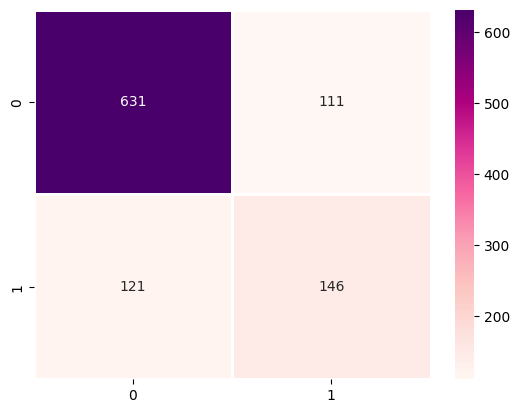


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   ----- 



,accuracy,precision,recall,f1_score
model,,,,
Xgboost,0.777998,0.778533,0.777998,0.778262
RandomForestClassifer,0.776016,0.770950,0.776016,0.773147
Support_vector,0.770069,0.767384,0.770069,0.768645
Logistics_regressor,0.767096,0.806635,0.767096,0.777722
Decision_Tree,0.717542,0.733450,0.717542,0.724102
KNeighbors,0.697721,0.747597,0.697721,0.712487


In [71]:
all_models_eval, trained_models= model_report()
all_models_eval

### **MODEL EVALUATION**

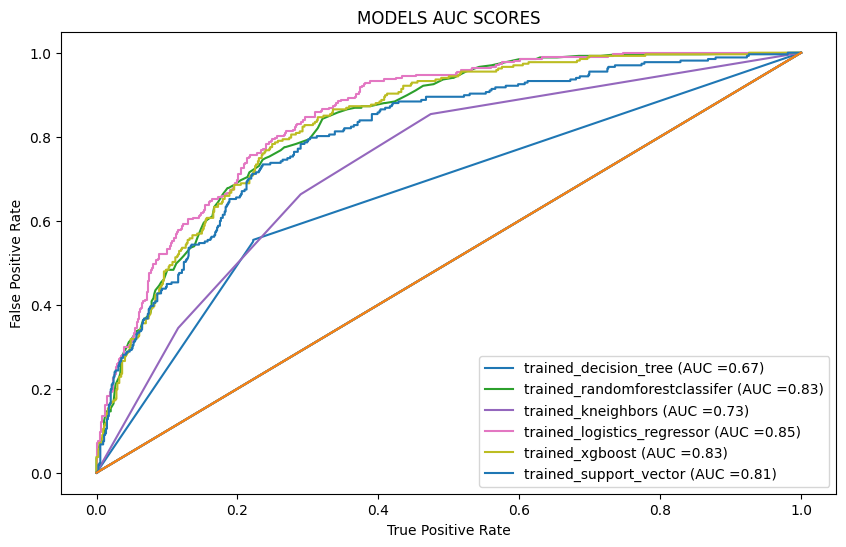

In [72]:
## Check for the AUC SCORE AND ROC CURVE OF ALL THE MODELS
fig, ax = plt.subplots(figsize=(10,6))

all_roc_data ={}

for model_name, pipeline in trained_models.items():
    y_score = pipeline.predict_proba(X_eval)[:,  1]
    
    fpr, tpr, thresholds = roc_curve(y_evaled, y_score)
    
    roc_auc = auc(fpr, tpr)
    
    roc_data_df = pd.DataFrame({"False Positive Rate" : fpr, "True Positive rate ": tpr, "Thresholds": thresholds})
    
    all_roc_data[model_name]=roc_data_df
    
    ax.plot(fpr,tpr, label=f"{model_name} (AUC ={roc_auc:.2f})")
    
    ax.plot([0,1],[0,1])
    ax.set_ylabel("False Positive Rate")
    ax.set_xlabel("True Positive Rate")
    plt.legend()
    plt.title("MODELS AUC SCORES")
    
plt.show()

### **BUSINESS INSIGHT**

--- **Imbalanced models** Gradient boosting is performing well at 80% across all precision, recall, accuracy and f1 score. 
--- Followed by Xgboost performing at 80% to 79% across precision, recall, accuracy and f1 score. Logistics regressor was the third performing model at 79% cutting across all metric scores.

--- **Balanced models** Xgboost classifier has taken the lead but performing at 77% across precision, accuracy, recall and f1 score,
--- Followed closely with Random forest classifier and support vector machines with a score of 77% and 76%. 

--- Looking closely across both trained functions the models are performing at a rate closely to each other apart from Xgboost which had a higher accuracy.

--- For the AUC scores we can see that Xgboost and random forest are at 83% hence able to predict our target variable but still lower on the 1.0 curve.

--- While the model still remains to be imbalanced on our target variable, through the confusion matrix we can be able to see that the true positives of customers churning have been predicted better than the scores of the false positive.

## **HYPERPARAMETER TUNING** 

### *XGBOOST CLASSIFIER*

In [73]:
xgb_clf1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical_pipeline', 'preprocessor__categorical_pipeline', 'preprocessor__numerical_pipeline__memory', 'preprocessor__numerical_pipeline__steps', 'preprocessor__numerical_pipeline__verbose', 'preprocessor__numerical_pipeline__numerical_imputer', 'preprocessor__numerical_pipeline__scaler', 'preprocessor__numerical_pipeline__numerical_imputer__add_indicator', 'preprocessor__numerical_pipeline__numerical_imputer__copy', 'preprocessor__numerical_pipeline__numerical_imputer__fill_value', 'preprocessor__numerical_pipeline__numerical_imputer__keep_empty_features', 'preprocessor__numerical_pipeline__numerical_imputer__missing_values', 'preprocessor__numerical_pipeline__numerical_imput

In [74]:
xgbmodel= xgb_clf1.fit(X_train, y_trained)

**CROSS_VALIDATION**

In [75]:
# Defining the number of folds for cross-validation and the range of estimators
# cv = [2, 4, 6]
# Syntax for range() = range(start, stop*, steps); the value for stop is not included when selecting the values
cv = list(range(2, 7))

# Using a loop to cross-validate with each number in the range of estimators
for c in cv:
    score = cross_val_score(estimator= xgbmodel, X= X_train, y= y_trained, cv= c, n_jobs=-1).mean()
    print(f"The model's average score after cross-validation at {c} folds is: {round(score,5)}")

The model's average score after cross-validation at 2 folds is: 0.77188
The model's average score after cross-validation at 3 folds is: 0.77412
The model's average score after cross-validation at 4 folds is: 0.77833
The model's average score after cross-validation at 5 folds is: 0.78155
The model's average score after cross-validation at 6 folds is: 0.77932


In [76]:
xgb_params = {
    'classifier__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma':[0.001, 0.01, 0.1, 1]  
}

In [77]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=xgbmodel,
                           param_grid=xgb_params,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_trained)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_eval, y_evaled)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8400317734487387
Test score: 0.8529609214896473


In [78]:
# Running the RandomizedSearch Cross-Validation with the above set of Parameters
xgb_cv_model = RandomizedSearchCV(estimator=xgbmodel,
                                    param_distributions=xgb_params,
                                    n_iter= 5,
                                    cv= KFold(n_splits = 5,shuffle=True),
                                    random_state=42,
                                    n_jobs=-1)

# Fitting the model to the training data
xgb_cv_model.fit(X_train, y_trained)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical_pipeline',
                                                                               Pipeline(steps=[('numerical_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                                              ('...
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__gamma': [0.001, 0.01, 0.1,
                                                              1],
                                        'classifier__learning_rate': [0.001,
                                                                      0.01, 0.1,
                                                                      1, 10,
                                                                      100,
                                                                      1000]},
                   random_state=42)

In [79]:
xgb_cv_model.best_params_

{'classifier__learning_rate': 0.01, 'classifier__gamma': 0.01}

In [80]:
model_trained =[]
xgb_cv_model.fit(X_train, y_trained)
model_trained.append(xgb_cv_model)
y_eval_pred = xgb_cv_model.predict(X_eval)
print(classification_report(y_true=y_evaled, y_pred=y_eval_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       742
           1       0.58      0.71      0.64       267

    accuracy                           0.78      1009
   macro avg       0.73      0.76      0.74      1009
weighted avg       0.80      0.78      0.79      1009



In [81]:
best_exgb=xgb_cv_model.best_estimator_

**VISUALIZATION OF CONFUSION MATRIX**

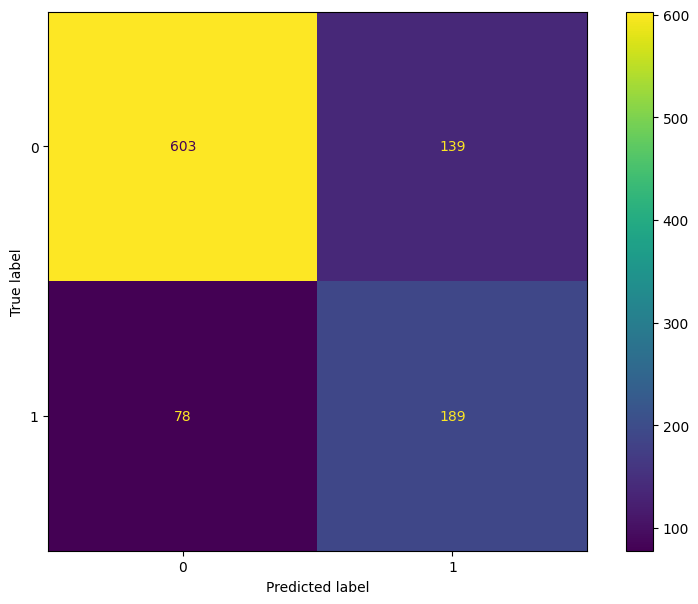

In [82]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred_RF = xgb_cv_model.best_estimator_.predict(X_eval)

cm = confusion_matrix(y_evaled, y_pred_RF, labels=xgb_cv_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_cv_model.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

**OBSERVATIONS**

--- From our cross validation we can see that the model test score is actually higher than the cross validation score with 84% and 85% respectively.

--- After hyperparameter tuning our model scored increased at 79% thus with more hyperparameter tuning, the performance of our model can increase.

--- Using our confusion matrix the model's true positive which is one has also increased significantly with the false positive decreasing hence our model is able to predict well on our csutomers

### *SUPPORT VECTOR MACHINE*

In [83]:
svc_clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical_pipeline', 'preprocessor__categorical_pipeline', 'preprocessor__numerical_pipeline__memory', 'preprocessor__numerical_pipeline__steps', 'preprocessor__numerical_pipeline__verbose', 'preprocessor__numerical_pipeline__numerical_imputer', 'preprocessor__numerical_pipeline__scaler', 'preprocessor__numerical_pipeline__numerical_imputer__add_indicator', 'preprocessor__numerical_pipeline__numerical_imputer__copy', 'preprocessor__numerical_pipeline__numerical_imputer__fill_value', 'preprocessor__numerical_pipeline__numerical_imputer__keep_empty_features', 'preprocessor__numerical_pipeline__numerical_imputer__missing_values', 'preprocessor__numerical_pipeline__numerical_imput

In [84]:
svc_model= svc_clf.fit(X_train,y_trained)

**CROSS_VALIDATION**

In [85]:
# Defining the number of folds for cross-validation and the range of estimators
# cv = [2, 4, 6]
# Syntax for range() = range(start, stop*, steps); the value for stop is not included when selecting the values
cv = list(range(2, 7))

# Using a loop to cross-validate with each number in the range of estimators
for c in cv:
    score = cross_val_score(estimator= svc_model, X= X_train, y= y_trained, cv= c, n_jobs=-1).mean()
    print(f"The model's average score after cross-validation at {c} folds is: {round(score,5)}")

The model's average score after cross-validation at 2 folds is: 0.77907
The model's average score after cross-validation at 3 folds is: 0.77436
The model's average score after cross-validation at 4 folds is: 0.78031
The model's average score after cross-validation at 5 folds is: 0.76667
The model's average score after cross-validation at 6 folds is: 0.77436


In [86]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=42)
 
param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}   
grid_search = GridSearchCV(estimator=svc_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_trained)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_eval, y_evaled)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8150418960742648
Test score: 0.8204316706542696


In [87]:
# create param grid
svc_grid = {'classifier__C': [0.1,1, 10, 100], 
              'classifier__gamma': [1,0.1,0.01,0.001]} 

In [88]:
# Running the RandomizedSearch Cross-Validation with the above set of Parameters
svc_cv_model = RandomizedSearchCV(estimator=svc_model,
                                    param_distributions=svc_grid,
                                    n_iter= 5,
                                    cv= KFold(n_splits = 5,shuffle=True),
                                    random_state=42,
                                    n_jobs=-1)

# Fitting the model to the training data
svc_cv_model.fit(X_train, y_trained)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical_pipeline',
                                                                               Pipeline(steps=[('numerical_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                                              ('...
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                                             ('smote',
                                              SMOTE(k_neighbors=3,
                                                    random_state=42,
                                                    sampling_strategy=0.8)),
                                             ('classifier',
                                              SVC(gamma=0.5,
                                                  probability=True))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 10, 100],
                                        'classifier__gamma': [1, 0.1, 0.01,
                                                              0.001]},
                   random_state=42)

In [89]:
svc_cv_model.best_params_

{'classifier__gamma': 0.01, 'classifier__C': 100}

In [90]:
model_trained =[]
svc_cv_model.fit(X_train, y_trained)
model_trained.append(svc_cv_model)
y_eval_pred = svc_cv_model.predict(X_eval)
print(classification_report(y_true=y_evaled, y_pred=y_eval_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       742
           1       0.59      0.69      0.63       267

    accuracy                           0.79      1009
   macro avg       0.73      0.76      0.74      1009
weighted avg       0.80      0.79      0.79      1009



In [91]:
svc_cv_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strate...
                                                  Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod'],
      dtype='object'))])),
                ('smote',
                 SMOTE(k_neighbors=3, random_state=42, sampling_strategy=0.8)),
                ('classifier', SVC(C=100, gamma=0.01, probability=True))])

**VISUALIZATION OF CONFUSION MATRIX**

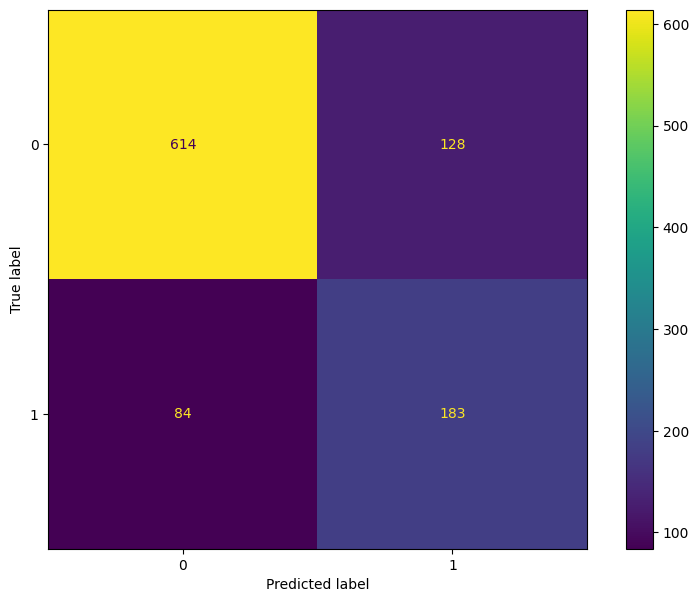

In [92]:
# the confusion matrix

fig, ax = plt.subplots(figsize=(10,7))
y_pred_RF = svc_cv_model.best_estimator_.predict(X_eval)

cm = confusion_matrix(y_evaled, y_pred_RF, labels=svc_cv_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=svc_cv_model.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

**OBSERVATIONS**

--- The model's test score on unseen data was higher as compared to the cross validation ranging from 82% to 81% 

--- After hyperparameter tuning, the model's accuracy showed a remarkable increase at 79% with precision score at 80% and the rest at 79%. Therefore, with more tuning the model's performance can increase.

--- Plotting with confusion matrix, we can atest to the model that it has been able to predict well on the true positive and reducing the false positives.

### *RANDOMFOREST CLASSIFIER*

In [93]:
rd_clf1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical_pipeline', 'preprocessor__categorical_pipeline', 'preprocessor__numerical_pipeline__memory', 'preprocessor__numerical_pipeline__steps', 'preprocessor__numerical_pipeline__verbose', 'preprocessor__numerical_pipeline__numerical_imputer', 'preprocessor__numerical_pipeline__scaler', 'preprocessor__numerical_pipeline__numerical_imputer__add_indicator', 'preprocessor__numerical_pipeline__numerical_imputer__copy', 'preprocessor__numerical_pipeline__numerical_imputer__fill_value', 'preprocessor__numerical_pipeline__numerical_imputer__keep_empty_features', 'preprocessor__numerical_pipeline__numerical_imputer__missing_values', 'preprocessor__numerical_pipeline__numerical_imput

In [94]:
rd_model=rd_clf1.fit(X_train, y_trained)

**CROSS_VALIDATION**

In [95]:
# Defining the number of folds for cross-validation and the range of estimators
# cv = [2, 4, 6]
# Syntax for range() = range(start, stop*, steps); the value for stop is not included when selecting the values
cv = list(range(2, 7))

# Using a loop to cross-validate with each number in the range of estimators
for c in cv:
    score = cross_val_score(estimator= rd_model, X= X_train, y= y_trained, cv= c, n_jobs=-1).mean()
    print(f"The model's average score after cross-validation at {c} folds is: {round(score,5)}")

The model's average score after cross-validation at 2 folds is: 0.78428
The model's average score after cross-validation at 3 folds is: 0.78825
The model's average score after cross-validation at 4 folds is: 0.78676
The model's average score after cross-validation at 5 folds is: 0.78849
The model's average score after cross-validation at 6 folds is: 0.79097


In [96]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=42)
 
param_grid={'classifier__n_estimators': [100, 200, 300]}   
grid_search = GridSearchCV(estimator=rd_model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_trained)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_eval, y_evaled)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8230277004431699
Test score: 0.836561272802528


In [97]:
rd_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [ None,2,5,10],
    'classifier__criterion':['gini', 'entropy'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [2,5,10],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

In [98]:
# Running the RandomizedSearch Cross-Validation with the above set of Parameters
rd_ft_cv_model = RandomizedSearchCV(estimator=rd_model,
                                     param_distributions=rd_grid,
                                     n_iter=5,
                                     cv=KFold(n_splits = 6,shuffle=True),
                                     random_state=42,
                                     n_jobs=-1)

# Fitting the model to the training data
rd_ft_cv_model.fit(X_train, y_trained)

RandomizedSearchCV(cv=KFold(n_splits=6, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numerical_pipeline',
                                                                               Pipeline(steps=[('numerical_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                                              ('...
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__criterion': ['gini',
                                                                  'entropy'],
                                        'classifier__max_depth': [None, 2, 5,
                                                                  10],
                                        'classifier__max_features': ['auto',
                                                                     'sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': [2, 5,
                                                                         10],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42)

In [99]:
rd_ft_cv_model.best_params_

{'classifier__n_estimators': 100,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 2,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 10,
 'classifier__criterion': 'gini'}

In [100]:
rd_ft_cv_model.fit(X_train, y_trained)
model_trained.append(rd_ft_cv_model)
y_eval_pred = rd_ft_cv_model.predict(X_eval)
print(classification_report(y_true=y_evaled, y_pred=y_eval_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       742
           1       0.60      0.67      0.63       267

    accuracy                           0.79      1009
   macro avg       0.73      0.75      0.74      1009
weighted avg       0.80      0.79      0.80      1009



In [101]:
best_estimator= rd_ft_cv_model.best_estimator_

**VISUALIZATION OF CONFUSION MATRIX**

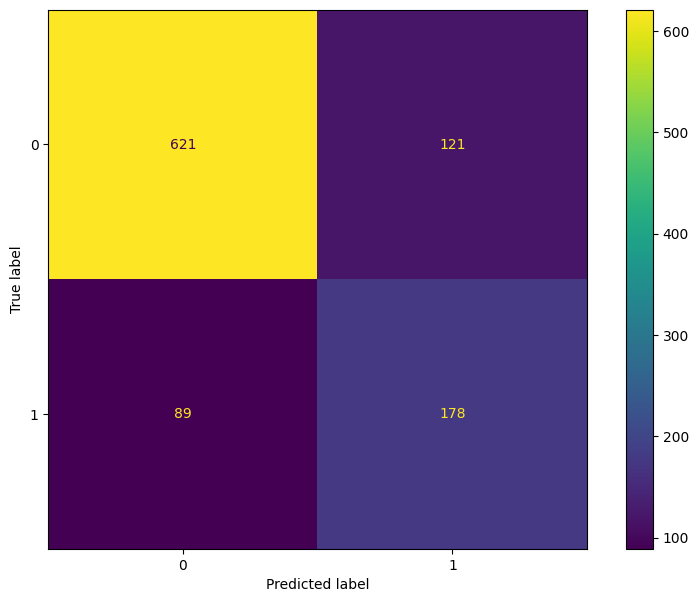

In [102]:
# the confusion matrix
fig, ax = plt.subplots(figsize=(10,7))
y_pred_RF = rd_ft_cv_model.best_estimator_.predict(X_eval)

cm = confusion_matrix(y_evaled, y_pred_RF, labels=rd_ft_cv_model.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rd_ft_cv_model.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

**OBSERVATIONS**

--- From our model,its performance on unseen data is higher at 83%, whereas the cross validation score ranging at 82%.

--- Using hyperparameter tuning has also improved the efficiency of the model significantly with precision and f1 score at 80% and accuracy at 79% meaning the model could improve better with usage of more parameters.

--- Through the parameters the model has been able to predict our churn customers well in the confusion matrix reducing the false positives to 89 while true positives at 178.

--- **From the 3 models Random forest classifier was the chosen model to test my dataset**

### **TEST MODEL**

In [103]:
test = pd.read_excel("data files\Telco-churn-last-2000.xlsx")
test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


**EDA**

In [104]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [105]:
test.duplicated().sum()

0

In [106]:
test.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [107]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,2000.0,0.161500,0.368084,0.00,0.00,0.0,0.000,1.00
tenure,2000.0,31.853000,24.632677,0.00,8.00,27.0,55.000,72.00
MonthlyCharges,2000.0,63.933325,30.136858,18.25,34.25,69.8,89.275,118.75


In [108]:
test.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2000,2000,7613-LLQFO,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2000,2,Female,1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2000.0,NaN,NaN,NaN,0.1615,0.368084,0.0,0.0,0.0,0.0,1.0
Partner,2000,2,No,1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2000,2,No,1451,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2000.0,NaN,NaN,NaN,31.853,24.632677,0.0,8.0,27.0,55.0,72.0
PhoneService,2000,2,Yes,1807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2000,3,No,966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2000,3,Fiber optic,848,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2000,3,No,991,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**DATA CLEANING**

In [109]:
# replace and lower column names
test.columns = [col_name.lower() for col_name in test.columns]
test.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55


In [110]:
# drop customer ID Column
test.drop('customerid', axis=1, inplace=True )

In [111]:
test['totalcharges']= pd.to_numeric(test['totalcharges'],errors='coerce')

**PREDICTION**

In [112]:
predictions= rd_ft_cv_model.predict(test)
predictions

array([1, 0, 0, ..., 1, 0, 0])

In [113]:
targ.inverse_transform(predictions)

array(['Yes', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype=object)

### **SAVE THE MODELS**

In [116]:
# Save the pipeline
with open('XGB.pkl', 'wb') as f:
    pickle.dump(xgb_cv_model, f) 

In [117]:
# Save the pipeline
with open('rdclf.pkl', 'wb') as f:
    pickle.dump(rd_clf1, f) 

In [118]:
# Save the pipeline
with open('xgbclf.pkl', 'wb') as f:
    pickle.dump(xgb_clf1, f) 

In [114]:
# Save the pipeline
with open('random.pkl', 'wb') as f:
    pickle.dump(rd_ft_cv_model, f) 

In [115]:
with open('labelenc.pkl', 'wb') as f:
    pickle.dump(targ, f)